# Imports

In [170]:
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
from textstat.textstat import textstat
from gensim.corpora import wikicorpus
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline
# Make it pretty
plt.style.use('ggplot')

# Read in data

In [146]:
file = '../data/enwiki.observations.text_wp10.30k.tsv'
raw_data = pd.read_csv(file, sep='\t', header=None)

In [147]:
data = pd.DataFrame(data=list(raw_data[0].apply(literal_eval)))
data = data[data['text'] != ""]
data = data[data['text'].str.contains("#redirect") == False]
data = data[data['text'].str.contains("may refer to:\n\n*") == False]
data = data[data['text'].str.contains("can refer to:\n") == False]
data = data[data['text'].str.contains("could refer to:\n") == False]
data = data[data['text'].str.contains("#REDIRECT") == False]
data = data[data['text'].str.contains("== Matches ==\n:") == False]
data = data[data['text'].str.contains("{{underconstruction") == False]

In [148]:
classes = {"stub": 0, "start": 1, "c": 2, "b": 3, "ga": 4, "fa": 5} 
data["label"] = data['label'].map(classes)

# Practice pipeline with part of data

In [154]:
data1000 = data[:4000]

# Random Forest Test

In [127]:
def clean_wiki_markup(raw_article):
    semi_cleaned_article = wikicorpus.filter_wiki(raw_article)
    cleaned_article = semi_cleaned_article.replace("\n", "").replace("\'", "").replace("()", "").replace("=", "").replace("|alt","").replace("\xa0","")
    return cleaned_article
def find_num_categories(raw_article):
    return raw_article.count("[[Category:")
def find_num_images(raw_article):
    return raw_article.count("[[Image:")
def find_num_ISBN(raw_article):
    return raw_article.count("ISBN")
def find_num_references(raw_article):
    return raw_article.count("</ref>")
def find_article_length(cleaned_article):
    return len(cleaned_article)
def find_num_difficult_words(cleaned_article):
    return textstat.difficult_words(cleaned_article)
def find_dale_chall_readability_score(cleaned_article):
    return textstat.dale_chall_readability_score(cleaned_article)
def find_automated_readability_index(cleaned_article):
    return textstat.automated_readability_index(cleaned_article)
def find_linsear_write_formula(cleaned_article):
    return textstat.linsear_write_formula(cleaned_article)
def find_gunning_fog_index(cleaned_article):
    return textstat.gunning_fog(cleaned_article)
def find_syllable_count(cleaned_article):
    return textstat.syllable_count(cleaned_article)
def find_lexicon_count(cleaned_article):
    return textstat.lexicon_count(cleaned_article, removepunct=True)
def find_sentence_count(cleaned_article):
    return textstat.sentence_count(cleaned_article)
def find_smog_index(cleaned_article):
    return textstat.smog_index(cleaned_article)
def find_num_web_citations(raw_article):
    return raw_article.count("{{cite web")
def find_num_book_citations(raw_article):
    return raw_article.count("{{cite book")
def find_num_news_citations(raw_article):
    return raw_article.count("{{cite news")
def find_num_quotes(raw_article):
    return raw_article.count("quote=")
def find_num_h3_headers(raw_article):
    return raw_article.count("\n===")
def find_num_internal_links(raw_article):
    return (raw_article.count("[[") // 2)
def find_num_h2_headers(raw_article):
    return (raw_article.count("\n==") - find_num_h3_headers(raw_article))
def find_num_note_tags(raw_article):
    return raw_article.count("{{note")
def find_num_bullet_points(raw_article):
    return (raw_article.count("*"))
def find_num_underlines(raw_article):
    return (raw_article.count("<u>"))
def find_num_journal_citations(raw_article):
    return (raw_article.count("{{cite journal"))
def find_num_about_links(raw_article):
    return (raw_article.count("{{About"))
def find_num_wikitables(raw_article):
    return (raw_article.count('class="wikitable'))
def find_num_footnotes(raw_article):
    return raw_article.count("{{")

In [129]:
pruned_df = data1000
clean_cols = {}
clean_cols['cleaned_text'] = data['text'].apply(clean_wiki_markup)
clean_cols['num_web_citations'] = data['text'].apply(find_num_web_citations)
clean_cols['num_book_citations'] = data1000['text'].apply(find_num_book_citations)
clean_cols['num_news_citations'] = data1000['text'].apply(find_num_news_citations)
clean_cols['num_quotes'] = data1000['text'].apply(find_num_quotes)
clean_cols['num_h3_headers'] = data1000['text'].apply(find_num_h3_headers)
clean_cols['num_internal_links'] = data1000['text'].apply(find_num_internal_links)
clean_cols['num_h2_headers'] = data1000['text'].apply(find_num_h2_headers)
clean_cols['has_infobox'] = data1000['text'].str.contains('{{Infobox').astype(int)
clean_cols['num_categories'] = data1000['text'].apply(find_num_categories)
clean_cols['num_images'] = data1000['text'].apply(find_num_images)
clean_cols['num_ISBN'] = data1000['text'].apply(find_num_ISBN)
clean_cols['num_references'] = data1000['text'].apply(find_num_references)
clean_cols['article_length'] = data1000['text'].apply(find_article_length)
clean_cols['num_difficult_words'] = data1000['cleaned_text'].apply(find_num_difficult_words)
clean_cols['dale_chall_readability_score'] = data1000['cleaned_text'].apply(find_dale_chall_readability_score)
clean_cols['readability_index'] = data1000['cleaned_text'].apply(find_automated_readability_index)
clean_cols['linsear_write_formula'] = data1000['cleaned_text'].apply(find_linsear_write_formula)
clean_cols['gunning_fog_index'] = data1000['cleaned_text'].apply(find_gunning_fog_index)
clean_cols['smog_index'] = data1000['cleaned_text'].apply(find_smog_index)
clean_cols['syllable_count'] = data1000['cleaned_text'].apply(find_syllable_count)
clean_cols['lexicon_count'] = data1000['cleaned_text'].apply(find_lexicon_count)
clean_cols['sentence_count'] = data1000['cleaned_text'].apply(find_sentence_count)
clean_cols['num_footnotes'] = data1000['text'].apply(find_num_footnotes)
clean_cols['num_note_tags'] = data1000['text'].apply(find_num_note_tags)
clean_cols['num_underlines'] = data1000['text'].apply(find_num_underlines)
clean_cols['num_journal_citations'] = data1000['text'].apply(find_num_journal_citations)
clean_cols['num_about_links'] = data1000['text'].apply(find_num_about_links)
clean_cols['num_wikitables'] = data1000['text'].apply(find_num_wikitables)

In [130]:
clean_df = pd.DataFrame(clean_cols)

In [134]:
clean_df.dropna(inplace=True)

In [137]:
clean_df.drop(columns='cleaned_text', inplace=True)

In [157]:
y = data1000.label.values

# Test/Train Split

In [158]:
X_train, X_test, y_train, y_test = train_test_split(clean_df.values, y, test_size=0.20, random_state=910)

# Random Forrest

In [160]:
RF = RandomForestRegressor(n_estimators=10, random_state=910, )

In [161]:
RF.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=910, verbose=0, warm_start=False)

In [162]:
predictions = RF.predict(X_test)

In [163]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, predictions)

0.8388374999999999

AttributeError: Unknown property jitter

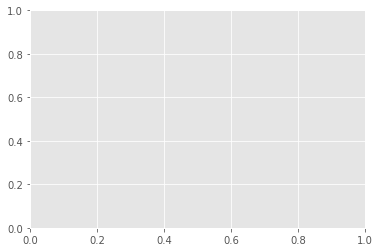

In [172]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, alpha=.1, jitter=.1)

In [164]:
dataset = pd.DataFrame({'predictions':predictions, 'true_value':y_test})

In [165]:
violin_data = [dataset[dataset.true_value==i].predictions for i in range(0,6)]

KeyError: 0

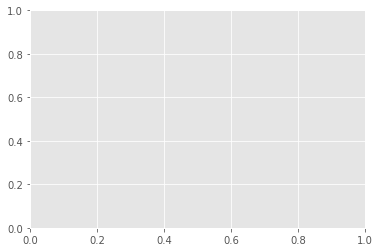

In [166]:
plt.violinplot(violin_data, showmeans=True)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs. ALS Recommender Predicted Ratings')
plt.show()

array([5, 5, 2, ..., 3, 2, 3])

In [287]:
data['cleaned_text'] = data['text'].apply(clean_wiki_markup)
data['lexicon_count'] = data['cleaned_text'].apply(find_lexicon_count)
data['sentence_count'] = data['cleaned_text'].apply(find_sentence_count)
data['article_length'] = data['text'].apply(find_article_length)
data['num_difficult_words'] = data['cleaned_text'].apply(find_num_difficult_words)

In [222]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = '../data/glove.6B.50d.txt'
word2vec_output_file = 'glove.6B.50d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400001, 50)

In [ ]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.50d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [230]:
# calculate: (X - Z) + Y = ?
#result = model.most_similar(positive=['Y', 'X'], negative=['Z'], topn=1)
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

[('queen', 0.8523603677749634)]


In [266]:
from collections import Counter
article = Counter(wikicorpus.tokenize(data1000['cleaned_text'][0]))

In [263]:
from itertools import dropwhile
for key, count in dropwhile(lambda key_count: key_count[1] >= 20, article.most_common()):
    del article[key]

In [267]:
article2 - article

Counter()

In [169]:
data1000

,label,page_title,project,text,timestamp
0,5,Funerary art,visual arts,[[Image:GD-FR-Paris-Louvre-Sculptures034.JPG|3...,20100504203659
1,5,Battle of Warsaw (1920),russia,{{Infobox Military Conflict\n|conflict=Battle ...,20070111175847
2,2,Henry Digby (Royal Navy officer),biography,{{Use British English|date=August 2011}}\n{{Us...,20111205102850
3,2,Ottawa Redblacks,canadian football,{{Use mdy dates|date=May 2013}}\n{{Infobox CFL...,20140513220942
4,2,Qimonda,germany,{{Infobox_Company |\n company_name = Qimond...,20090315202104
5,1,"Ocracoke, North Carolina",project north carolina,{{Infobox Settlement\n|official_name ...,20080911150022
6,2,Erik Wilhelm,biography,{{construction}}\n\n{{Infobox NFL player\n| im...,20141125183748
7,0,Kolibite,bulgaria,{{Infobox settlement \n|official_name =Kolibit...,20120524063028
8,3,Edouard Borovansky,ballet,{{Infobox Person\n| name = Edouard Borovansk...,20110208153146
9,0,Jacek Wiśniewski,poland,{{Football player infobox\n| playername= Jacek...,20090105062145


In [18]:
from sklearn.feature_extraction.text import HashingVectorizer
hash_vectorizer = HashingVectorizer()
hash_vectorizer.fit(data1000['cleaned_text'])
X_transformed = hash_vectorizer.transform(data1000['cleaned_text'])
hash_df = pd.DataFrame(X_transformed.todense())
y = data1000.label.values
X_train, X_test, y_train, y_test = train_test_split(hash_df.values, y, test_size=0.20, random_state=910)
RF = RandomForestRegressor(n_estimators=500, random_state=910)
RF.fit(X_train, y_train)
predictions = RF.predict(X_test)
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, predictions)

KeyboardInterrupt: 

In [89]:
wiki_article_stats = '../data/article_stats.tsv'
raw_stats_data = pd.read_csv(wiki_article_stats, sep='\t')

In [100]:
raw_stats_data.sort_values(by='max_importance', ascending=True)

,page_id,page_title,max_importance,min_importance,mean_importance,inlinks,direct_inlinks,inlinks_from_redirects,organic_inlinks,organic_direct_inlinks,organic_inlinks_from_redirects,views,direct_views,views_from_redirects
0,12,Anarchism,High,Top,1.7273,7319,5279,2040,3694,2176,1518,69791,58381,11410
117656,287314,"Frederick_Hamilton-Temple-Blackwood,_1st_Marqu...",High,Mid,3.0000,541,458,83,327,259,68,2134,1704,430
394407,1678370,Slats_Gill,High,Unknown,3.4000,394,391,3,35,32,3,545,522,23
394406,1678366,Ed_Marlo,High,High,2.0000,21,20,1,18,17,1,488,467,21
1072992,7285375,Who_Shot_Ya?,High,High,2.0000,70,65,5,28,25,3,4227,4001,226
117660,287341,Billy_Martin,High,Unknown,3.7000,1425,1424,1,422,421,1,12949,12930,19
117661,287362,George_Kuchar,High,Mid,3.0000,77,77,0,64,64,0,1568,1568,0
1717085,15342691,Sport_in_Jersey,High,High,2.0000,202,200,2,9,9,0,418,417,1
117655,287311,"All_Hail,_Liberia,_Hail!",High,Unknown,3.5000,92,90,2,15,14,1,814,779,35
923001,5781991,Ancient_constructions_of_Sri_Lanka,High,Top,1.5000,55,41,14,24,14,10,1150,883,267


In [97]:
wiki_clickstream = '../data/2015_01_clickstream.tsv'
raw_clickstream = pd.read_csv(wiki_clickstream, sep='\t', header=None)

In [98]:
raw_clickstream

,0,1,2,3,4
0,NaN,3632887,415,other-empty,!!
1,NaN,3632887,113,other-google,!!
2,NaN,3632887,33,other-wikipedia,!!
3,NaN,600744,25,other-yahoo,!!!
4,NaN,600744,1193,other-google,!!!
5,NaN,600744,1065,other-empty,!!!
6,25014178.0,600744,44,Jerry_Fuchs,!!!
7,34552784.0,600744,11,Flight_Facilities,!!!
8,4499.0,600744,21,Band,!!!
9,1446971.0,600744,14,Gold_Standard_Laboratories,!!!


In [ ]:
data1000['cleaned_text']